In [2]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' 
g = torch.Generator(device=device).manual_seed(5522)

In [3]:
words = open('names.txt', 'r').read().split()
words[:4]

['emma', 'olivia', 'ava', 'isabella']

In [4]:
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

block_size = 8

In [5]:
def build_dataset(words):
    X,Y = [],[]

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    print(X.shape, Y.shape)
    return X,Y

In [6]:
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [172]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in ** 0.5
        self.bias = torch.randn(fan_out, device=device) if bias else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] +([] if self.bias is None else [self.bias])
# =====================================================================================

class BatchNorm:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # learnable parameters
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        # to update while running
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)


    def __call__(self,x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


# =====================================================================================

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# =====================================================================================

class Embedding:

    def __init__(self, num_embd, emb_dim):
        self.weight = torch.randn((num_embd, emb_dim), device=device)

    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# =====================================================================================

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

# =====================================================================================

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [173]:
torch.manual_seed(42);

In [174]:
n_embd = 32
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2),
    
    Linear(n_embd*2, n_hidden, bias=False),
    BatchNorm(n_hidden),Tanh(),
    
    FlattenConsecutive(2),
    Linear(n_hidden*2, n_hidden, bias=False),
    BatchNorm(n_hidden),Tanh(),
    
    FlattenConsecutive(2),
    Linear(n_hidden*2, n_hidden, bias=False),
    BatchNorm(n_hidden),Tanh(),
    
    Linear(n_hidden, n_hidden, bias=False),
    BatchNorm(n_hidden),Tanh(),
    Linear(n_hidden,64),
    
    BatchNorm(64),Tanh(),
    Linear(64, vocab_size)
    
])

with torch.no_grad():
    model.layers[-1].weight *= 1

parameters = model.parameters()

for p in parameters:
    p.requires_grad = True
    p.data = p.data.to(device)
            
print(sum(p.nelement() for p in parameters))

102139


In [175]:
b = torch.randn(10,8,32)
n = 2

In [176]:
# k = b.view(10,4,64)
# 1-linear(64,128) ---> (10,8,128), 
# flatten(10,4,256) 

# 2-linear(256,128) ---> (10,4,128)
# flatten(10,2,256)

# 3-linear(256,128) ---> (10,2,128)
# flatten(10,256)

# 4-linear(256,128) ---> (10,128)
# 5-linear(128,64) ---> (10,64)
# 6-linear(64,27)


In [177]:
ix = torch.randint(0, Xtr.shape[0], (10,)) 
Xb,Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([10, 8])


tensor([[ 0,  0,  0,  0, 10, 15, 26, 25],
        [ 0,  0,  0,  0,  0,  8,  5, 18],
        [ 0,  0,  0, 12,  1, 25, 14,  5],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0,  0,  0, 14,  1],
        [ 0,  0,  0,  4,  1, 25, 22,  5],
        [ 1,  2,  5, 20,  8, 18, 15, 19],
        [ 0,  0,  0, 10,  1, 12,  5,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  2, 18,  5, 24]], device='cuda:0')

In [178]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (10, 8, 32)
FlattenConsecutive : (10, 4, 64)
Linear : (10, 4, 128)
BatchNorm : (10, 4, 128)
Tanh : (10, 4, 128)
FlattenConsecutive : (10, 2, 256)
Linear : (10, 2, 128)
BatchNorm : (10, 2, 128)
Tanh : (10, 2, 128)
FlattenConsecutive : (10, 256)
Linear : (10, 128)
BatchNorm : (10, 128)
Tanh : (10, 128)
Linear : (10, 128)
BatchNorm : (10, 128)
Tanh : (10, 128)
Linear : (10, 64)
BatchNorm : (10, 64)
Tanh : (10, 64)
Linear : (10, 27)


In [179]:
steps = 300000
batch_size = 64
lossi = []
log_lossi = []


In [180]:

for i in range(steps):
    
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    if i < 100000:
        lr = 0.1
    elif i < 200000:
        lr = 0.01
    else:
        lr = 0.001
    
    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:  # print every once in a while
        print(f'{i:7d}/{steps:7d}: {loss.item():4f}')
    lossi.append(loss.item())

    log_lossi.append(loss.log10().item())

    

      0/ 300000: 4.296749
   1000/ 300000: 2.491188
   2000/ 300000: 2.073997
   3000/ 300000: 2.157997
   4000/ 300000: 2.270918
   5000/ 300000: 2.222706
   6000/ 300000: 2.438344
   7000/ 300000: 1.950541
   8000/ 300000: 2.322195
   9000/ 300000: 1.835962
  10000/ 300000: 1.914538
  11000/ 300000: 2.283341
  12000/ 300000: 2.076250
  13000/ 300000: 2.240547
  14000/ 300000: 2.410439
  15000/ 300000: 2.073699
  16000/ 300000: 1.955155
  17000/ 300000: 2.089683
  18000/ 300000: 2.181967
  19000/ 300000: 1.947627
  20000/ 300000: 2.127049
  21000/ 300000: 1.987924
  22000/ 300000: 1.669817
  23000/ 300000: 1.719331
  24000/ 300000: 1.887588
  25000/ 300000: 1.944695
  26000/ 300000: 1.917820
  27000/ 300000: 1.820661
  28000/ 300000: 2.008563
  29000/ 300000: 1.623262
  30000/ 300000: 1.874124
  31000/ 300000: 1.785905
  32000/ 300000: 1.899074
  33000/ 300000: 1.740363
  34000/ 300000: 2.120971
  35000/ 300000: 2.060168
  36000/ 300000: 2.084005
  37000/ 300000: 2.060836
  38000/ 300

In [181]:
for layer in model.layers:
    layer.training = False

In [182]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train' : (Xtr,Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')


train 1.6384166479110718
val 2.0395069122314453
test 2.042480945587158


In [195]:

for _ in range(20):

    out = []
    context = [0] * block_size  # initialise with all..
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

eveleigh.
kani.
kylee.
ethan.
audringlan.
mirano.
evelynn.
irissa.
isam.
holdi.
toula.
chandler.
kyzah.
jadiel.
myleigha.
masai.
guralse.
siera.
dakoda.
adryan.


In [189]:
len(lossi)

300000

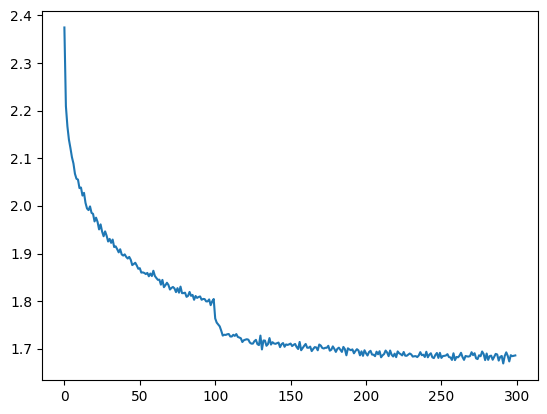

In [190]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

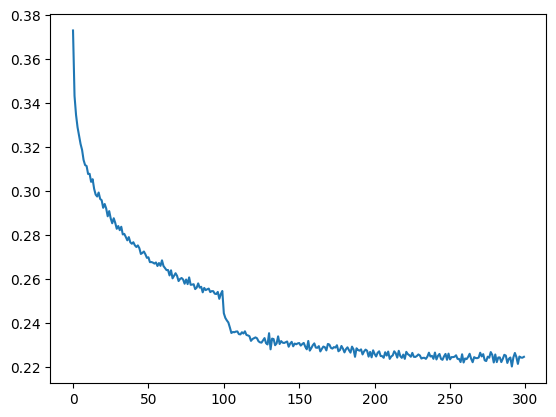

In [191]:
plt.plot(torch.tensor(log_lossi).view(-1, 1000).mean(1))

In [ ]:
# train 1.6360752582550049
# val 2.050616979598999
# test 2.041220188140869


train 1.6384166479110718
val 2.0395069122314453
test 2.042480945587158